## Replicating Explanation and Use of Uncertainty Quantified by Bayesian Neural Network Classifiers for Breast Histopathology Images

This notebook documents an experimental replication of the research presented in the paper titled `Explanation and Use of Uncertainty Quantified by Bayesian Neural Network Classifiers for Breast Histopathology Images,` which investigated breast histopathology image classification using a Bayesian CNN approach. The specific experiment replicated here compares the classification performance of three models:

*   TL-CNN: This model employs a VGG-16 architecture.
*   bayesian-CNN: This is the original Bayesian CNN model presented in the paper.
*   modified bayesian-CNN: This is the authors' proposed improvement to the original Bayesian CNN model.



In [1]:
import numpy as np
import torch
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

from keras.callbacks import EarlyStopping

In [29]:
torch.cuda.empty_cache()

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data Preparation

The experiment utilizes a publicly available breast histopathology image dataset from Kaggle, titled `Breast Histopathology Images` by Paul Mooney (2017). 


In [4]:
data_dir =r'D:\S2\Resources\B Histopatology Data'
os.listdir(data_dir)

['cancer', 'normal']

## Image preprocessing

The images have a dimension of `3 x 50 x 50 (Depth x Height x Width)` and are converted to the uint8 format. `Pixel-wise` normalization is performed using a method from OpenCV.

The dataset consists of two classes : cancer (1) and normal (0). By using `80% - 20%` data splitted into `train and validation`

In [5]:
def normalize_and_complement(x):
    x = x.astype('float64')
    return (255 - x) / 255.0

In [6]:
train_datagen = ImageDataGenerator(
                preprocessing_function=normalize_and_complement,
                validation_split = 0.2
                )

In [7]:
train_dt_generator = train_datagen.flow_from_directory(
    data_dir,
    shuffle=True,
    target_size=(50,50),
    subset= 'training',
)

validation_dt_generator= train_datagen.flow_from_directory(
    data_dir,
    shuffle=True,
    target_size=(50,50),
    subset= 'validation'
)

Found 222020 images belonging to 2 classes.
Found 55504 images belonging to 2 classes.


In [8]:
pretrained = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (50,50,3))

### TL-CNN

The architecture of `TL-CNN` followed `VGG-16` and used the weight of `VGG-16` pre-trained on the `ImageNet` dataset for classification and performed `transfer learning` to classify the histopathological data.



Based on paper, there were some strategies to solve the over-fitting from TL-CNN:
1. The use of L1 Regularization
2. The use of Dropout
3. The use of early stopping

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience =10)

In [18]:
for layer in pretrained.layers:
    layer.trainable = False

In [19]:
## TL_CNN (VGG-16 Architecture)
models = tf.keras.models.Sequential ([

    pretrained,
      
    # Fully Connected Layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')

])

In [20]:
models.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [21]:
models.fit(train_dt_generator,
            epochs=100,
            batch_size =64,
            validation_data=validation_dt_generator,
            callbacks =[early_stopping]
            )

Epoch 1/100
6939/6939 [==============================] - 186s 27ms/step - loss: 3.3336 - accuracy: 0.7748 - val_loss: 2.7622 - val_accuracy: 0.8003
Epoch 2/100
6939/6939 [==============================] - 183s 26ms/step - loss: 2.7966 - accuracy: 0.7815 - val_loss: 2.7962 - val_accuracy: 0.8001
Epoch 3/100
6939/6939 [==============================] - 181s 26ms/step - loss: 2.7929 - accuracy: 0.7821 - val_loss: 2.7478 - val_accuracy: 0.7970
Epoch 4/100
6939/6939 [==============================] - 197s 28ms/step - loss: 2.7913 - accuracy: 0.7799 - val_loss: 2.7817 - val_accuracy: 0.8046
Epoch 5/100
6939/6939 [==============================] - 189s 27ms/step - loss: 2.7895 - accuracy: 0.7776 - val_loss: 2.7702 - val_accuracy: 0.7984
Epoch 6/100
6939/6939 [==============================] - 181s 26ms/step - loss: 2.7878 - accuracy: 0.7784 - val_loss: 2.7866 - val_accuracy: 0.7973
Epoch 7/100
6939/6939 [==============================] - 181s 26ms/step - loss: 2.7874 - accuracy: 0.7771 - val_

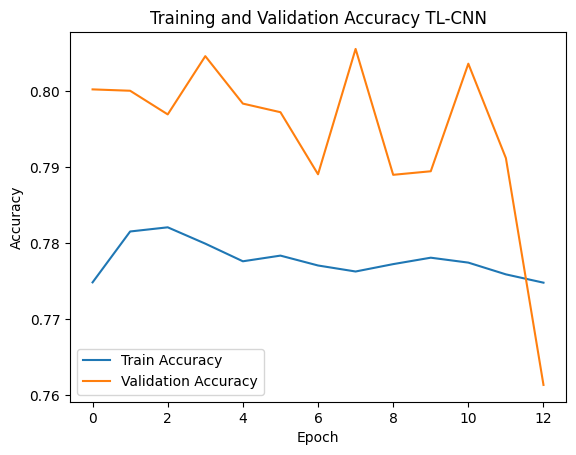

In [22]:
plt.plot(models.history.history['accuracy'], label='Train Accuracy')
plt.plot(models.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy TL-CNN')
plt.legend()
plt.savefig('Acc Graph TLCNN.jpg', dpi = 600)
plt.show()


### Bayesian-CNN  

All convolution layers are fixed as `(3 x 3)` with `stride = 1` and max pool layers are `(2 x 2)` with `stride = 2`

In [30]:
bayesian_cnn = tf.keras.models.Sequential ([
    #block 1
    tfp.layers.Convolution2DFlipout(16, (3,3), activation ='relu', input_shape=(50,50,3), strides = 1), #input
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),    

    #block 2
    tf.keras.layers.Conv2D(32, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(32, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),

    #block 3
    tf.keras.layers.Conv2D(64, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(128, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(256, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),    

    #Fully Connected
    tf.keras.layers.Flatten(),
    tfp.layers.DenseFlipout(512, activation = 'relu'), #FC1
    tfp.layers.DenseFlipout(2, activation ='sigmoid') # Output
        ])

C:\Users\Andreas Sahir\AppData\Local\anaconda3\envs\env_gpu\lib\site-packages\keras\engine\base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [31]:
bayesian_cnn.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [26]:
bayesian_cnn.fit(train_dt_generator,
            epochs=100,
            batch_size =128,
            validation_data=validation_dt_generator,
            callbacks =[early_stopping]
            )

Epoch 1/100
6939/6939 [==============================] - 99s 14ms/step - loss: 286226.6875 - accuracy: 0.7136 - val_loss: 0.5966 - val_accuracy: 0.7161
Epoch 2/100
6939/6939 [==============================] - 97s 14ms/step - loss: 0.6030 - accuracy: 0.7159 - val_loss: 0.5966 - val_accuracy: 0.7161
Epoch 3/100
6939/6939 [==============================] - 99s 14ms/step - loss: 0.5967 - accuracy: 0.7161 - val_loss: 0.5967 - val_accuracy: 0.7161
Epoch 4/100
6939/6939 [==============================] - 96s 14ms/step - loss: 0.5969 - accuracy: 0.7161 - val_loss: 0.5966 - val_accuracy: 0.7161
Epoch 5/100
6939/6939 [==============================] - 101s 15ms/step - loss: 0.5967 - accuracy: 0.7161 - val_loss: 0.5967 - val_accuracy: 0.7161
Epoch 6/100
6939/6939 [==============================] - 96s 14ms/step - loss: 0.5967 - accuracy: 0.7161 - val_loss: 0.5966 - val_accuracy: 0.7161
Epoch 7/100
6939/6939 [==============================] - 99s 14ms/step - loss: 0.5967 - accuracy: 0.7161 - val_l

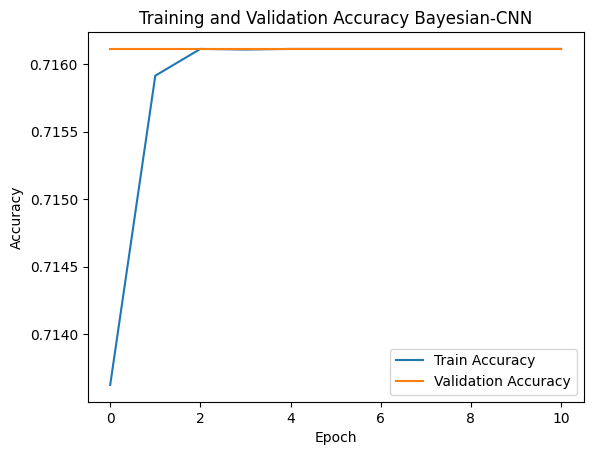

In [28]:
plt.plot(bayesian_cnn.history.history['accuracy'], label='Train Accuracy')
plt.plot(bayesian_cnn.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Bayesian-CNN')
plt.legend()
plt.savefig('Acc Graph Bayesian-CNN.jpg', dpi = 600)
plt.show()

### Modified Bayesian-CNN  

In Fully Connected Layer 1, instead of using ReLU, it uses a stochastic-adaptive ReLU

In [32]:
alpha = tf.Variable(initial_value=0.1, trainable = True)

def stochastic_adaptive_relu(x, alpha):
    f_k = x
    return alpha * f_k * tf.cast(f_k > 0, dtype=tf.float32)

In [33]:
class CustomDense(tfp.layers.DenseFlipout):
    def __init__ (self, units, **kwargs):
        super(CustomDense, self).__init__(units, **kwargs)

    def call(self, inputs):
        output = super(CustomDense, self).call(inputs)
        return stochastic_adaptive_relu(output, alpha)

In [34]:
modified_bayesian_cnn = tf.keras.models.Sequential ([
    #block 1
    tfp.layers.Convolution2DFlipout(32, (3,3), activation ='relu', input_shape=(50,50,3), strides = 1), #input
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),    

    #block 2
    tf.keras.layers.Conv2D(64, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(64, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),

    #block 3
    tf.keras.layers.Conv2D(128, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(128, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(128, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),    

    #Fully Connected
    tf.keras.layers.Flatten(),
    CustomDense(256), #FC1 with Stochastic-Adaptive Learning ReLU Activation Function
    tfp.layers.DenseFlipout(2, activation ='sigmoid') # Output
        ])

In [35]:
modified_bayesian_cnn.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [36]:
modified_bayesian_cnn.fit(train_dt_generator,
            epochs=100,
            batch_size =64,
            validation_data=validation_dt_generator,
            callbacks =[early_stopping]
            )

Epoch 1/100
6939/6939 [==============================] - 98s 14ms/step - loss: 290295.7500 - accuracy: 0.7192 - val_loss: 246461.5312 - val_accuracy: 0.7032
Epoch 2/100
6939/6939 [==============================] - 98s 14ms/step - loss: 204105.3125 - accuracy: 0.6959 - val_loss: 162749.2500 - val_accuracy: 0.6986
Epoch 3/100
6939/6939 [==============================] - 99s 14ms/step - loss: 124374.4922 - accuracy: 0.7151 - val_loss: 88080.8047 - val_accuracy: 0.7161
Epoch 4/100
6939/6939 [==============================] - 99s 14ms/step - loss: 57662.3945 - accuracy: 0.7161 - val_loss: 31116.0566 - val_accuracy: 0.7161
Epoch 5/100
6939/6939 [==============================] - 100s 14ms/step - loss: 14247.1230 - accuracy: 0.7161 - val_loss: 2878.9365 - val_accuracy: 0.7161
Epoch 6/100
6939/6939 [==============================] - 99s 14ms/step - loss: 539.6133 - accuracy: 0.7161 - val_loss: 0.6773 - val_accuracy: 0.7161
Epoch 7/100
6939/6939 [==============================] - 101s 15ms/step

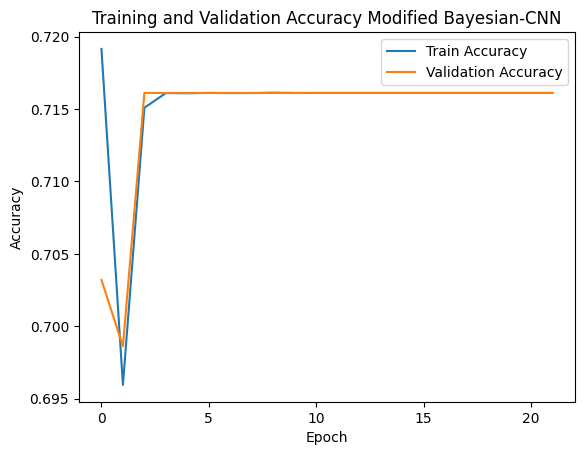

In [37]:
plt.plot(modified_bayesian_cnn.history.history['accuracy'], label='Train Accuracy')
plt.plot(modified_bayesian_cnn.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Modified Bayesian-CNN')
plt.legend()
plt.savefig('Acc Graph Modified Bayesian-CNN.jpg', dpi = 600)
plt.show()